# 四、季节性，假期效果和回归量
## 4.1 对假期和特征事件建模
如果需要专门对节假日或者其它的事件进行建模，你就必须得为此创建一个新的dataframe，其中包含两列（节假日 **holiday** 和日期戳 **ds** ），每行分别记录了每个出现的节假日。**这个数据框必须包含所有出现的节假日，不仅是历史数据集中还是待预测的时期中的**。如果这些节假日并没有在待预测的时期中被注明， Prophet 也会利用历史数据对它们建模，但预测未来时却不会使用这些模型来预测。

注：也就是说，在待预测的日期里，我们也必须指定所有出现的节假日。

你可以在这个数据框基础上再新建两列 **lower_window** 和 **upper_window** ，从而将节假日的时间扩展成一个区间 [ **lower_window** , **upper_window** ] 。举例来说，如果想将平安夜也加入到 “圣诞节” 里，就设置 **lower_window** = -1 , **upper_window** = 0 ;如果想将黑色星期五加入到 “感恩节” 里，就设置 **lower_window** = 0 , **upper_window** = 1 。

下面我们创建一个数据框，其中包含了所有佩顿 · 曼宁参加过的决赛日期：

In [1]:
import pandas as pd
from fbprophet import Prophet

In [2]:
playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16', 
                          '2010-01-24', '2010-02-07', '2011-01-08', 
                          '2013-01-12', '2014-01-12', '2014-01-19',
                          '2014-02-02', '2015-01-11', '2016-01-17', 
                          '2016-01-24', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1,
})
superbowls = pd.DataFrame({
    'holiday': 'superbowl',  
    'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),  
    'lower_window': 0,  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


上述代码中，**superbowls**的日期被包含在**playoffs**的日期数据框中。这就会造成超级碗日期的效应会在决赛日期的作用下叠加两次。

一旦这个数据框创建好了，就可以通过传入 **holidays** 参数使得在预测时考虑上节假日效应。这里我们仍以第一部分中佩顿 · 曼宁的数据为例：

In [3]:
df = pd.read_csv('examples/example_wp_log_peyton_manning.csv')

m = Prophet(holidays=holidays)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\PC-00001\Miniconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



The holiday effect can be seen in the **forecast** dataframe:

In [4]:
# 看一下假期的最后10行数据

forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.226744,1.196225
2191,2014-02-03,1.912758,1.365987
2532,2015-01-11,1.226744,0.000000
2533,2015-01-12,1.912758,0.000000
2901,2016-01-17,1.226744,0.000000
2902,2016-01-18,1.912758,0.000000
2908,2016-01-24,1.226744,0.000000
2909,2016-01-25,1.912758,0.000000
2922,2016-02-07,1.226744,1.196225
2923,2016-02-08,1.912758,1.365987


我将forecast导出后，发现多了几列数据如图。
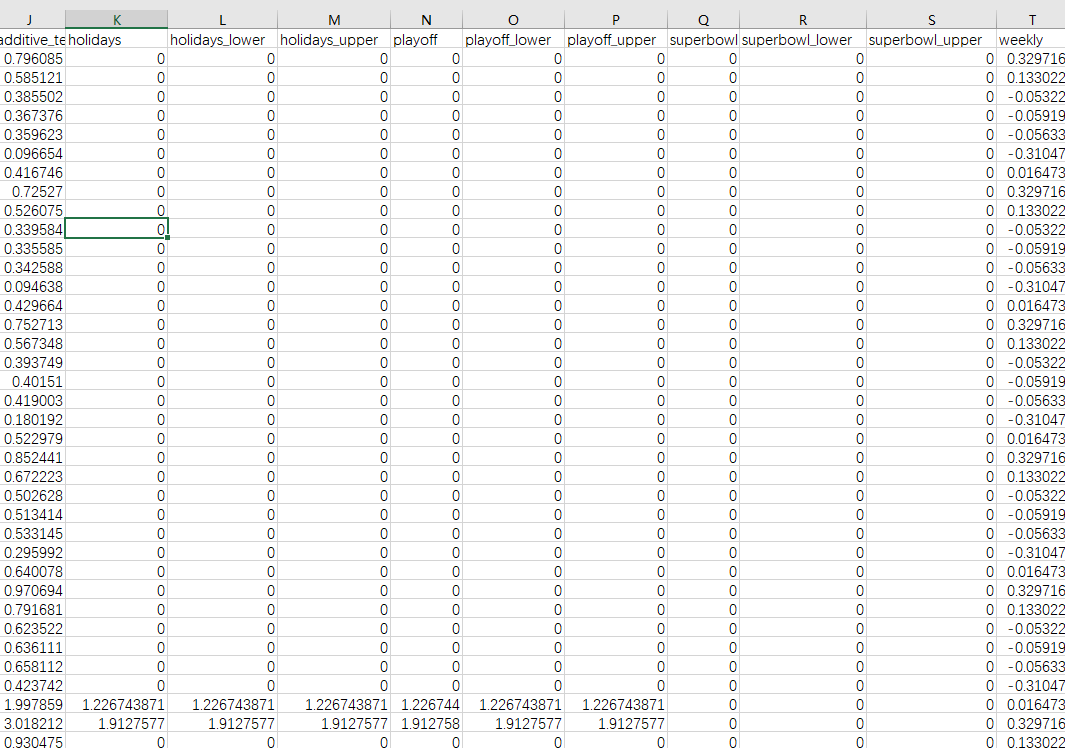

代码中 **[(forecast['playoff'] + forecast['superbowl']).abs() > 0]**
的意思是只显示数据绝对值大于0的项，因为大部分非节日的数据都是零，这样显示出来最后十行是没有意义的。

在成分分析的图中，如下所示，也可以看到节假日效应。我们可以发现，在决赛日期附近有一个**spike**，而在超级碗日期时**spike**则更为明显。

其实看着也没有那么明显。。

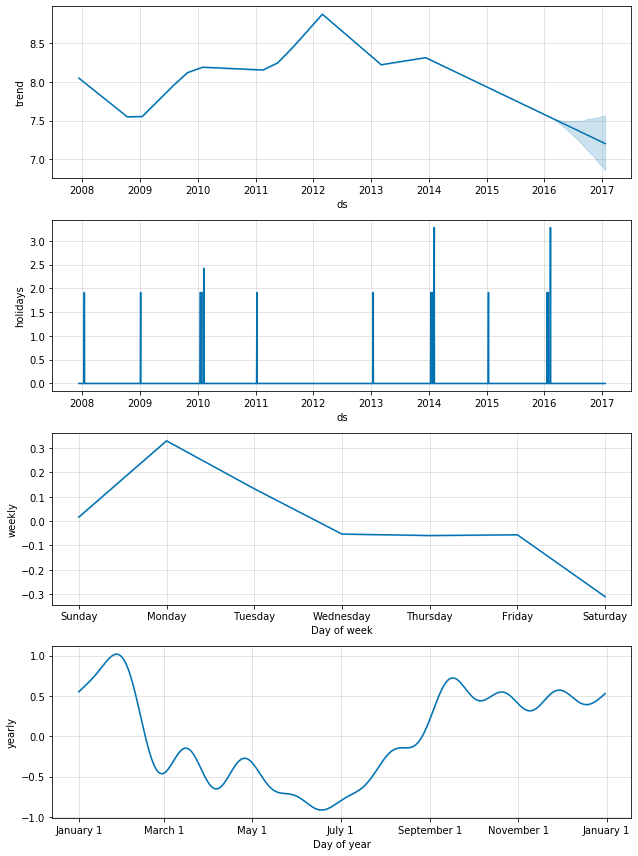

In [5]:
pd.plotting.register_matplotlib_converters()
fig = m.plot_components(forecast)

可以使用 plot_forecast_component（从fbprophet.plot导入）来画出独立的节假日的成分。类似如下代码：

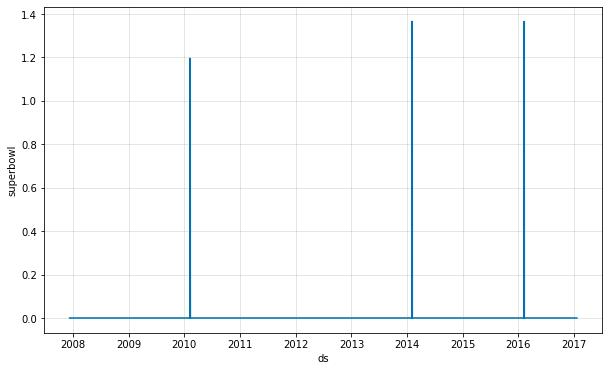

In [6]:
import fbprophet
from fbprophet.plot import plot_forecast_component
fig = fbprophet.plot.plot_forecast_component(m, forecast, 'superbowl')

对于上述代码的最后一句，prophet docs的描述是：

m.plot_forecast_component(m, forecast, 'superbowl')

但是这样写会发生错误，于是参考[github issue](https://github.com/facebook/prophet/pull/762)对代码进行了修改

# 4.2 Built-in Country Holidays 内置的各国节假日
Prophet内置了一些国家的节假日，你可以通过**add_country_holidays**参数在Python中使用。目前只内置了个别国家的节假日，后续会加入更多国家的节假日。使用代码如下：

In [7]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\PC-00001\Miniconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



你可以通过 **train_holiday_names** 参数查看所包括的节日名字：

In [8]:
m.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3     Martin Luther King, Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

可以看到，我们之前设定的playoff和superbowl排在前两位，后面的节日都是通过内置函数增加的。prophet提供的各国家的节假期信息可以在Python的**holiday**文件夹中看到。目前支持的国家[列表](https://github.com/dr-prodigy/python-holidays)可以在链接中查看。此外，最新一批支持的国家为：

Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Turkey (TU), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU)

在Python中大部分的节假日日期都被设定的很确切，因此适用于任何日期范围；如果日期超出了该国家的日期范围，程序就会发出警告。如果需要一个更大的日期范围，则可以使用[此脚本](https://github.com/facebook/prophet/blob/master/python/scripts/generate_holidays_file.py)将该文件替换为不同的日期范围。

和上面一样，我们画一下添加了节假日的components图像：

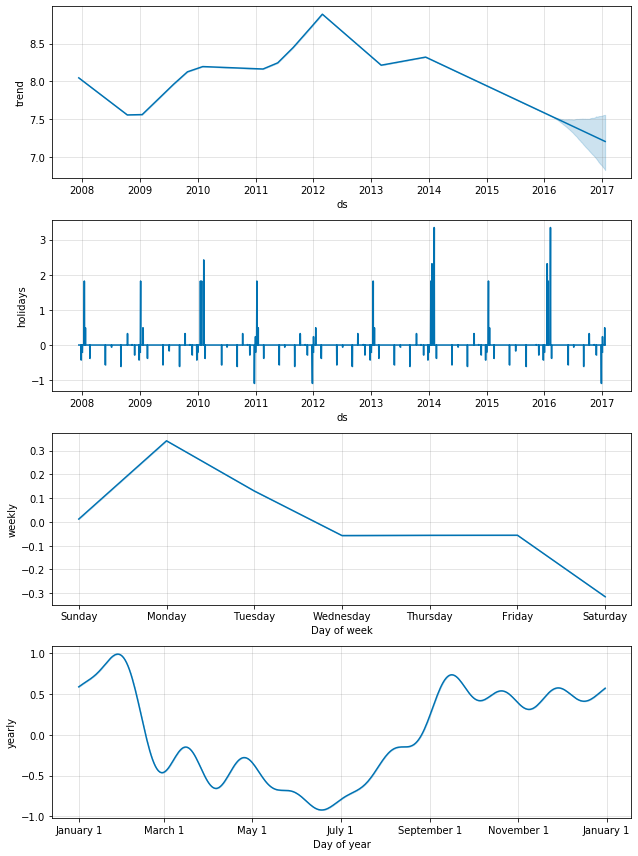

In [9]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

# 4.3 Fourier Order for Seasonalities 季节性的傅里叶级数

季节性是用**部分傅里叶和**估计的。有关完整的细节，请参阅[论文](https://peerj.com/preprints/3190/)，以及维基百科上的[这个图](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg)，以说明部分傅里叶和如何近似于一个线性周期信号。部分和(order)中的项数是一个参数，它决定了季节性的变化有多快。为了说明这一点， 我们仍用第一部分中佩顿 · 曼宁的数据。每年季节性的默认傅立叶级数是10，这就产生了这样的拟合:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


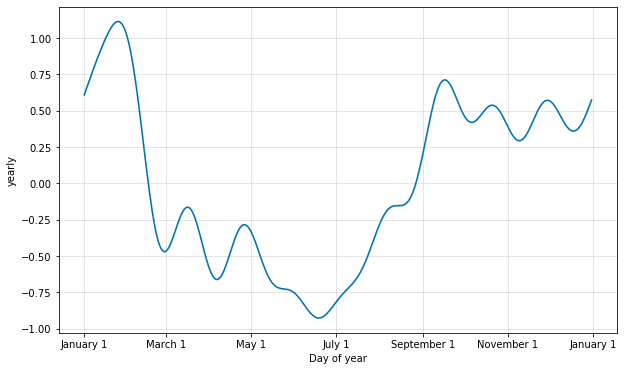

In [10]:
from fbprophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

默认值10通常是合适的，**但是当季节性需要适应更高频率的变化时，它们可以增加**，并且通常不那么平滑。在实例化模型时，可以为每个内置季节性指定傅立叶级数，这里增加到20: 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


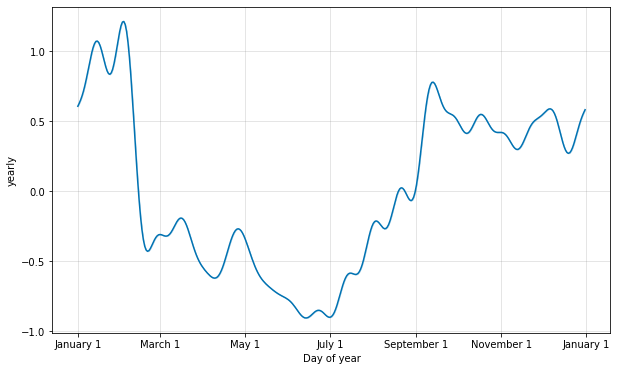

In [11]:
from fbprophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

可以看到，曲线更加的多变了。增加傅立叶项的数量可以使季节性适应更快的变化周期，但也可能导致过度拟合:N个傅立叶项对应于用于建模周期的2N个变量。

# 4.4 Specifying Custom Seasonalities 自定义季节性因素

如果时间序列超过两个周期，Prophet将默认适合**每周**和**每年**的季节性。对于子日（sub-daily ）时间序列，它也将适合每日的季节性。在Python中，可以使用**add_seasality**方法添加其它季节性(如每月、每季、每小时)。

这个函数的输入是一个名字，来表示季节性的周期，以及季节性的傅里叶order。作为参考，默认情况下，Prophet为**周季节性**设定的傅立叶order为3，为**年季节性**设定的为10。**add_seasality**的一个可选输入是该季节性组件的先验规模。

作为一个例子，我们仍使用佩顿 · 曼宁的数据，但是用每月的季节性替换每周的季节性。每月的季节性将出现在组件图中:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


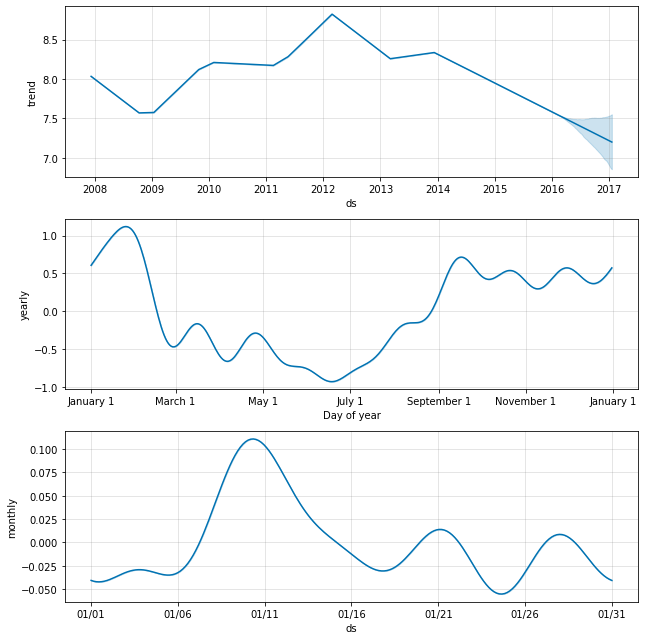

In [12]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

# 4.5 对节假日和季节性设定先验规模
如果发现节假日效应被过度拟合了，通过设置参数 **holidays_prior_scale** 可以调整它们的先验规模来使之平滑，默认下该值取 10 。

减少这个参数会降低假期效果:

In [13]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,playoff,superbowl
2190,2014-02-02,1.205517,0.959184
2191,2014-02-03,1.856860,0.907189
2532,2015-01-11,1.205517,0.000000
2533,2015-01-12,1.856860,0.000000
2901,2016-01-17,1.205517,0.000000
2902,2016-01-18,1.856860,0.000000
2908,2016-01-24,1.205517,0.000000
2909,2016-01-25,1.856860,0.000000
2922,2016-02-07,1.205517,0.959184
2923,2016-02-08,1.856860,0.907189


和之前相比，节假日效应的规模被减弱了，特别是对观测值较少的超级碗而言。类似的，还有一个 **seasonality_prior_scale** 参数可以用来调整模型对于季节性的拟合程度。 

可以通过在节假日的dataframe中包含一个列prior_scale来单独设置先验规模。独立的季节性的先验规模可以作为**add_seasonality**的参数传递。例如，可以使用以下方法设置每周季节性的先验规模:

In [14]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

# 4.6 附加的回归量
可以使用**add_regressor**方法将附加的回归量添加到模型的线性部分。**包含回归值的列需要同时出现在拟合数据格式（fit）和预测数据格式(predict)中**。例如，我们可以在NFL赛季的周日添加附加的效果。在成分图上，这种效果会出现在“extra_regre_”图中:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


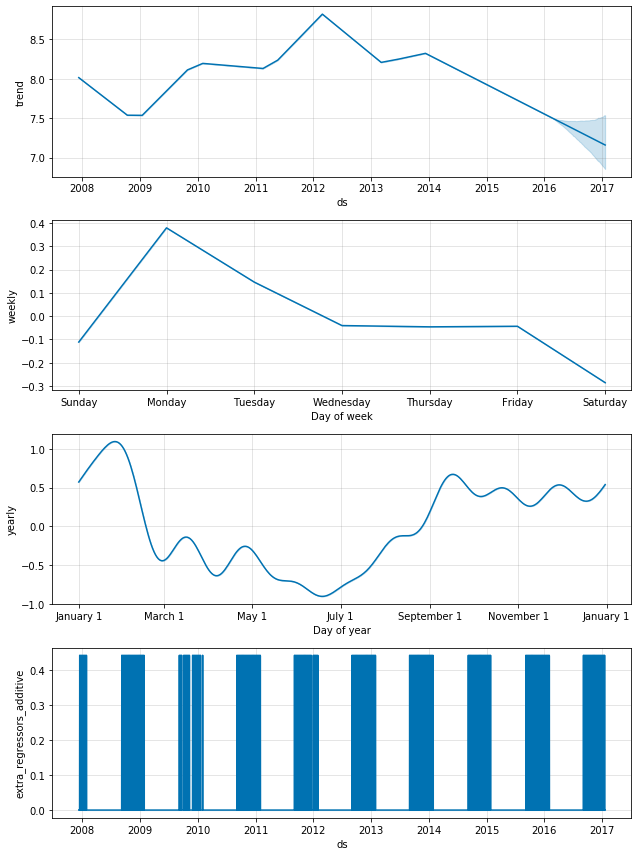

In [15]:
# 判断是否是NFL赛季的周日

def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday) 

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

NFL周日也可以使用之前描述的“节假日”的接口，通过创建一个过去和未来NFL周日的list。**add_regressor**函数为定义附加的线性回归函数提供了一个更通用的接口，特别是它不要求回归函数是二进制指示器。

**add_regressor**函数具有可选的参数，用于指定先验规模(默认情况下使用节假日先验规模)，和指定是否标准化回归量。**help(Prophet.add_regressor)**可以查看相关参数。

附加的回归量必须要知道历史和未来的日期。因此，它要么是已知未来值(比如nfl_sunday)，要么是其他地方已经单独预测出的结果。如果回归量在整个历史中都是不变的，则Prophet会引发一个错误，因为没有任何东西可以fit它。

附加的回归量被放在模型的线性分量中，所以依赖于附加的回归量时间序列作为底层模型的加法或乘法因子。